In [ ]:
# Exploration 13 폐렴아 기다려라 프로젝트


# 진행순서

1. 하이퍼파라미터 설정
2. 데이터 불러오기
3. 데이터 전처리
4. 데이터 시각화
5. CNN 모델링
6. 모델 훈련
7. 모델 평가

# 후기

그냥 주어진 노드에  augmentation 기법만 추가해도 0.875는 나온다.(배치 = 16, 에포크 =10)  
물론 뽀록빨.. 다시 돌려보니 0.85에 가깝게 나온다.         
그래도 recall은 준수한 것을 보니, 의료 판단용으로 볼 때 괜찮은 것 같다.       
재밌는 건 배치사이즈를 늘리면 accracy가 떨어지는 경향을 보인다.      


# 결과

## 하이퍼 파라미터 조정 전 결과 
Batch_size = 16 / Epochs = 25 : accuracy: 0.8045 - precision: 0.7617 // loss: 1.0946          

## 하이퍼 파라미터 조정 후 결과
Batch_size = 32 / Epochs = 20 : accuracy: 0.7468 - precision: 0.7117          
Batch_size = 32 / Epochs = 10 : accuracy: 0.7516 - precision: 0.7196           
Batch_size = 16 / Epochs = 10 : accuracy: 0.8750 - precision: 0.8768 // loss: 0.4385 loss가 특이하게 적음            
Batch_size = 16 / Epochs = 20 : accuracy: 0.7917 - precision: 0.7559 // loss: 0.6887        
Batch_size = 8 / Epochs = 10 : accuracy: 0.8446 - precision: 0.8220 // loss: 0.4468         
Batch_size = 8 / Epochs = 20 : accuracy: 0.8333 - precision: 0.8017 // loss: 0.5706

# Step 0. 프로젝트 : 폐렴 진단기 성능개선
우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

### Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
# 가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.
# 우리가 이번 프로젝트에서 사용할 패키지 목록입니다.

import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [13]:
# 앞으로 필요한 변수들을 생성합니다.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16 

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180] # 이미지 크기를 180*180으로 만들거다

# EPOCH 크기 변수
EPOCHS = 10 # 미니배치 16개씩 뽑아서 전체 학습하는 행위를 25번 할거다 

print("ROOT_PATH 는",ROOT_PATH, "입니다.") # 경로 출력

## batch_size는 두 배, Epochs는 25에서 10으로 줄인다.

ROOT_PATH 는 /home/aiffel/aiffel 입니다.


### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [3]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*')) # train folder 내부 전체 파일
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*')) # test folder 내부 전체 파일
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')) # val folder 내부 전체 파일

print("train folder 내부 전체 파일 개수",len(train_filenames)) # train folder 내부 전체 파일 개수
print("test folder 내부 전체 파일 개수 ",len(test_filenames)) # test folder 내부 전체 파일 개수 
print("val folder 내부 전체 파일 개수",len(val_filenames)) # val folder 내부 전체 파일 개수

print("\n")

# train과 val 개수 조절
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print("조절한 뒤 train data의 개수 :",len(train_filenames))
print("조절한 뒤 val data의 개수 :",len(val_filenames))

print("\n")


# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 파악 
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print("\n")
      
# tf.data 인스턴스를 만들어 봅시다. 
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# Train 데이터 셋 개수, validation 데이터 셋 갯수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))
print("Validating images count: " + str(VAL_IMG_COUNT))

train folder 내부 전체 파일 개수 5216
test folder 내부 전체 파일 개수  624
val folder 내부 전체 파일 개수 16


조절한 뒤 train data의 개수 : 4185
조절한 뒤 val data의 개수 : 1047


Normal images count in training set: 1084
Pneumonia images count in training set: 3101


Training images count: 4185
Validating images count: 1047


In [4]:
# 이름을 라벨 데이터로 만들어주는 함수 설정
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  


# 이미지 크기를 변환하는 함수
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3) # 채널은 RGB를 말하는 것 같다.
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)


def process_path(file_path):
    label = get_label(file_path) # 라벨을 가져온다. 0과 1의 형태
    img = tf.io.read_file(file_path) # 이미지 불러오기
    img = decode_img(img) # 이미지 리사이즈
    return img, label

In [5]:
# 위의 함수들을 train data, val data 인스턴스에 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.



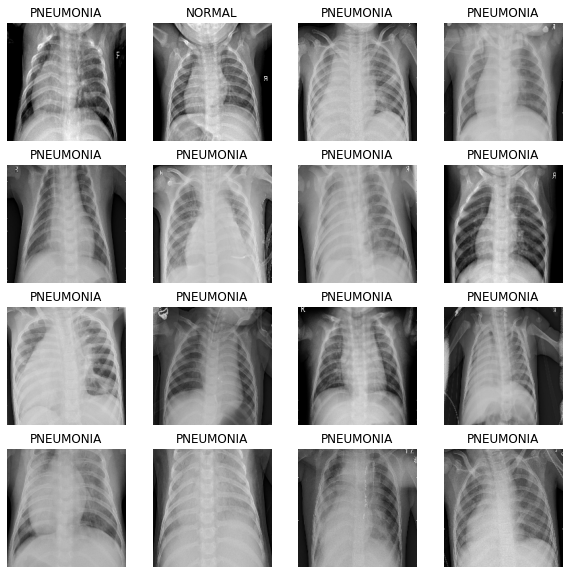

In [7]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16): # 0~15까지
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:# 존재하면? 1이라면 출력해라 라는 의미인가?
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.



In [8]:
# 필요한 함수 설정

# Convolution block을 만듭니다. 
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


# Dense Block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [9]:
# 모델 만들기

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?



In [10]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0)) # 정상일 경우 가중치
print('Weight for class 1: {:.2f}'.format(weight_for_1)) # 폐렴일 경우 가중치

Weight for class 0: 1.93
Weight for class 1: 0.67


### Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.



In [11]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [14]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 42s 160ms/step - loss: 0.3711 - accuracy: 0.8223 - precision: 0.9523 - recall: 0.8004 - val_loss: 0.6411 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 39s 148ms/step - loss: 0.2217 - accuracy: 0.9131 - precision: 0.9733 - recall: 0.9076 - val_loss: 1.1449 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 39s 149ms/step - loss: 0.2050 - accuracy: 0.9191 - precision: 0.9738 - recall: 0.9152 - val_loss: 0.1383 - val_accuracy: 0.9462 - val_precision: 0.9945 - val_recall: 0.9329
Epoch 4/10
261/261 [==============================] - 39s 150ms/step - loss: 0.1853 - accuracy: 0.9363 - precision: 0.9777 - recall: 0.9354 - val_loss: 0.1055 - val_accuracy: 0.9587 - val_precision: 0.9646 - val_recall: 0.9807
Epoch 5/10
261/261 [==============================] - 39s 151ms/step - loss: 0.1728 - accura

### Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

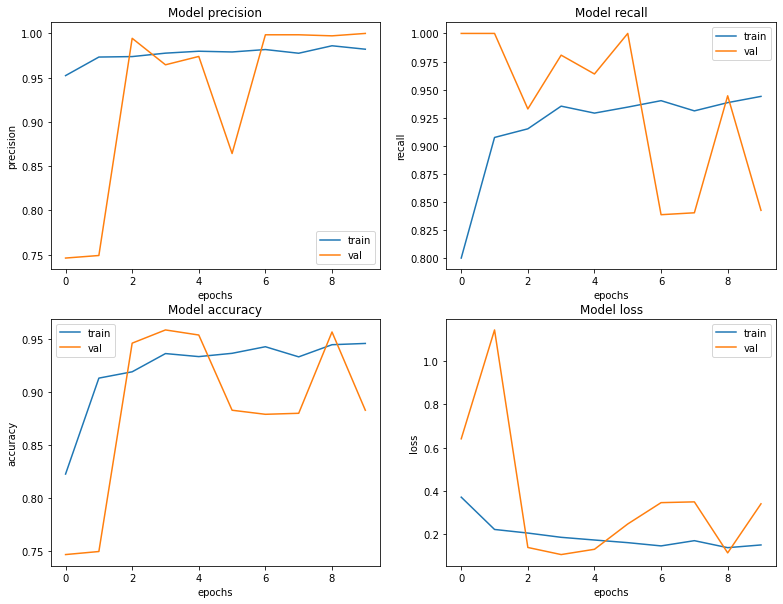

In [15]:
# 7. 결과 확인
# 이제 결과를 확인해보겠습니다. 
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

fig, ax = plt.subplots(2, 2, figsize=(13, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [16]:
# 테스트데이터 전처리
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [17]:
# 테스트 데이터로 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 113ms/step - loss: 0.4226 - accuracy: 0.8478 - precision: 0.8912 - recall: 0.8615
